!/usr/bin/env python
coding: utf-8

# M2 - Agentic AI - Improving SQL Generation with Reflection

## 1. Introduction
### 1.1. Lab overview

In this lab, you will explore how the reflection pattern can improve an agentic workflow that converts natural language questions to database queries written in SQL. You’ll see how an agent can spot issues in its own outputs, refine them, and improve it’s response before giving a final answer.

### 🎯 1.2 Learning outcome

You will practice applying the reflection pattern to improve an agentic workflow’s ability to write SQL queries. To do this, you will code a reflection step into the workflow, so the agent:

* Reviews its own intermediate results (such as draft SQL or tool outputs).
* Identifies errors or gaps.
* Checks its responses and tool use.
* Refines the output before submitting the final answer.

## 2. Setup: Initialize Environment and Client

In this step, you will prepare your workspace so you can start coding right away. You will:

1. **Import core Python libraries**

   * `json` for handling structured data.
   * `pandas` for working with tabular data.
   * `dotenv` to load environment variables (e.g., API keys).

2. **Load environment variables**
   This ensures your workspace is properly configured with the necessary keys and settings.

3. **Import the `utils.py` module**
   This file contains helper functions that you will use to format outputs and support later steps in the workflow.

**Note:** If you want to explore the contents of `utils.py`, go to the top menu and select **File > Open**.


In [7]:
import json
import utils
import pandas as pd
from dotenv import load_dotenv

load_dotenv()



True

### 2.1 Getting started with AISuite

The labs in this course will make use of a package called **aisuite** that makes it easy to call LLMs hosted by different model providers. 

Now, initialize the `aisuite client`. This client gives you a single, unified way to connect and interact with different LLMs — so you don't have to worry about each model having its own setup.


In [8]:
import aisuite as ai

client = ai.Client()





### 2.2. Set Up the Database

In this step, you will create a local SQLite database called **`products.db`**.
The database will be automatically filled with randomly generated product data.
You will use this data later in the lab to practice and test your SQL queries.

In [6]:
utils.create_transactions_db()





SQLite database 'products.db' created with a single 'transactions' table (event-sourced).


### 2.3. Inspect the Database Schema

You can inspect the table schema by executing the cell below.


In [4]:
utils.print_html(utils.get_schema('products.db'))





### 2.4. Understanding the Schema

In this table, every row represents an **event** (insert, restock, sale, or price update). Analytics such as stock levels, sales, or pricing trends are all derived from these events.

<div style="border:1px solid #93c5fd; border-left:6px solid #3b82f6; background:#eff6ff; border-radius:6px; padding:12px 14px; color:#1e3a8a; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">  
<strong>🔎 Schema overview:</strong><br><br>  
• <code>id</code> → unique event ID (autoincrement).<br>  
• <code>product_id</code>, <code>product_name</code>, <code>brand</code>, <code>category</code>, <code>color</code> → identify the product.<br>  
• <code>action</code> → type of event (<em>insert</em>, <em>restock</em>, <em>sale</em>, <em>price_update</em>).<br>  
• <code>qty_delta</code> → stock change (+ for insert/restock, – for sale, 0 for price updates).<br>  
• <code>unit_price</code> → price at that moment (NULL for restock).<br>  
• <code>notes</code> → optional description of the event.<br>  
• <code>ts</code> → timestamp when the event was logged.<br>  
</div>  

> With this schema, you can always reconstruct the **current state** (stock, latest price, total sales) by aggregating the event history.


## 3. Build a SQL Generator

### 3.1. Use an LLM to Query a Database

In this step, you will use a function that turns your natural-language questions into SQL queries.

You provide your question and the database schema as input. The LLM then generates the SQL query that answers your question.

This way, **you** can focus on asking questions while the model takes care of writing the query.


#### 3.1.1. Generate the First SQL Query

Run the cell below to see how **`generate_sql`** creates the **first version (V1)** of an SQL query for the `transactions` table, starting from a plain-English question.

Just provide the **question**, the **schema**, and the **model name**, and the function will return the initial query draft.


In [10]:
# Example usage of generate_sql

# We provide the schema as a string
schema = """
Table name: transactions
id (INTEGER)
product_id (INTEGER)
product_name (TEXT)
brand (TEXT)
category (TEXT)
color (TEXT)
action (TEXT)
qty_delta (INTEGER)
unit_price (REAL)
notes (TEXT)
ts (DATETIME)
"""

# We ask a question about the data in natural language
question = "Which color of product has the highest total sales?"

utils.print_html(question, title="User Question")






In [11]:
def generate_sql(question: str, schema: str, model: str) -> str:
    prompt = f"""
    You are a SQL assistant. Given the schema and the user's question, write a SQL query for SQLite.

    Schema:
    {schema}

    User question:
    {question}

    Respond with the SQL only.
    """
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )
    return response.choices[0].message.content.strip()



In [12]:
# Generate the SQL query using the specified model
sql_V1 = generate_sql(question, schema, model="openai:gpt-4.1")

# Display the generated SQL query
utils.print_html(sql_V1, title="SQL Query V1")

#### 3.1.2. Query Execution

Now you will execute the **first version (V1) of the SQL query** and inspect its results. This step is important because it allows you to verify whether the query generated by the LLM actually retrieves the information you were expecting from the database.  

- **`utils.execute_sql(...)`**: runs the generated SQL query (V1) against the `products.db` database and returns the output as a pandas DataFrame. Working with DataFrames makes it easier to inspect, analyze, and pass results into later steps of the workflow.  

- **`utils.print_html(...)`**: takes the DataFrame and renders it as a neatly formatted HTML table in the notebook. This makes the raw output more readable and helps you quickly spot if the query result is aligned with the user's question.


In [ ]:
# Execute the generated SQL query (sql_V1) against the products.db database.
# The result is returned as a pandas DataFrame.
df_sql_V1 = utils.execute_sql(sql_V1, db_path='products.db')

# Render the DataFrame as an HTML table in the notebook.
# This makes the query output easier to read and interpret.
utils.print_html(df_sql_V1, title="Output of SQL Query V1 - ❌ Does NOT fully answer the question")


color,total_sales
blue,-190571.46


### 3.2. Improving SQL Queries with Reflection

In this section, you will learn how to **improve SQL queries using reflection**.

First, the LLM can review only the **SQL text** against the question and schema, and propose improvements if needed.

Then, the LLM can also consider the **actual query execution results** to catch subtle issues such as negative totals, missing filters, or grouping errors.

Together, these approaches show how reflection makes your SQL workflow more **reliable and accurate**—by first checking the logic on paper and then validating it against real data.

#### 3.2.1. V1 Output Issue

<div style="border:1px solid #ef4444; border-left:6px solid #dc2626; background:#fee2e2; border-radius:6px; padding:12px 14px; color:#7f1d1d; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

❌ <strong>V1 Output Issue:</strong> The query result does not fully answer the question, because the total sales value is <em>negative</em> (`-190571.46`).  
<br><br>
In this dataset, a <code>qty_delta</code> is recorded as a **negative number for sales** (inventory leaving) and as a **positive number for returns or restocks** (inventory added). The query used <code>SUM(qty_delta)</code>, so when summing across transactions, the negatives dominate and produce a negative total.  
<br>
This means the SQL is technically valid but semantically incorrect — total sales should not be expressed as a negative value.  
<br>
➡️ This issue <strong>evidences the need for reflection</strong>: the model must refine its logic (for example, multiplying <code>qty_delta</code> by <code>-1</code> when calculating sales, or applying <code>ABS()</code>) so that the final query reflects true sales totals.  

</div>


#### 3.2.2. First Attempt: Refine a SQL Query

In this function, you ask an LLM to **review** a SQL query against the original question and the schema. The model reflects on whether the query fully answers the question and, if not, proposes an improved version.

* **Inputs**:
  * the user's **question**
  * the **original SQL query**
  * the **table schema**

* **Outputs**:
  * **feedback** → a short evaluation (e.g., "valid but missing a date filter")
  * **refined_sql** → the final SQL (unchanged if correct, or updated if improvements are needed)

This function does **not execute SQL**. It only inspects the query and suggests refinements when the logic doesn't perfectly match the intent.


In [ ]:
def refine_sql(
    question: str,
    sql_query: str,
    schema: str,
    model: str,
) -> tuple[str, str]:
    """
    Reflect on whether a query's *shown output* answers the question,
    and propose an improved SQL if needed.
    Returns (feedback, refined_sql).
    """
    prompt = f"""
You are a SQL reviewer and refiner.

User asked:
{question}

Original SQL:
{sql_query}

Table Schema:
{schema}

Step 1: Briefly evaluate if the SQL OUTPUT fully answers the user's question.
Step 2: If improvement is needed, provide a refined SQL query for SQLite.
If the original SQL is already correct, return it unchanged.

Return STRICT JSON with two fields:
{{
  "feedback": "<1-3 sentences explaining the gap or confirming correctness>",
  "refined_sql": "<final SQL to run>"
}}
"""
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    content = response.choices[0].message.content
    try:
        obj = json.loads(content)
        feedback = str(obj.get("feedback", "")).strip()
        refined_sql = str(obj.get("refined_sql", sql_query)).strip()
        if not refined_sql:
            refined_sql = sql_query
    except Exception:
        # Fallback if model doesn't return valid JSON
        feedback = content.strip()
        refined_sql = sql_query

    return feedback, refined_sql


##### Running the Refinement (V1 → V2)

Run the following cell to produce the **refined SQL query (V2)**. This step will:

* Display the **initial SQL query (V1)** generated in Section 3.1 for the question *"Which color of product has the highest total sales?"*
* Show the model's **feedback** and its **refined SQL proposal (V2)**.
* Execute the **original SQL (V1)** against the database and present its **actual output**, so you can see why refinement was needed.


In [ ]:
# Example: refine the generated SQL (V1 → V2)

feedback, sql_V2 = refine_sql(
    question=question,
    sql_query=sql_V1,   # <- comes from generate_sql() (V1)
    schema=schema, # <- we reuse the schema from section 3.1
    model="openai:gpt-4.1"
)

# Display the original prompt
utils.print_html(question, title="User Question")

# --- V1 ---
utils.print_html(sql_V1, title="Generated SQL Query (V1)")

# Execute and show V1 output
df_sql_V1 = utils.execute_sql(sql_V1, db_path='products.db')
utils.print_html(df_sql_V1, title="SQL Output of V1 - ❌ Does NOT fully answer the question")

# --- Feedback + V2 ---
utils.print_html(feedback, title="Feedback on V1")
utils.print_html(sql_V2, title="Refined SQL Query (V2)")

# Execute and show V2 output
df_sql_V2 = utils.execute_sql(sql_V2, db_path='products.db')
utils.print_html(df_sql_V2, title="SQL Output of V2 - ❌ Does NOT fully answer the question")


color,total_sales
blue,-190571.46


color,total_sales
blue,-190571.46


##### ❌ Why V2 Still Fails

<div style="border:1px solid #fecaca; border-left:6px solid #dc2626; background:#fee2e2; border-radius:6px; padding:12px 14px; color:#7f1d1d; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

❌ **As you can see...**  
Even though the generated SQL looked correct and the feedback confirmed it, the **actual query results** show a negative `total_sales` value.  

As mentioned before, this happened because the SQL multiplied `qty_delta * unit_price` without considering that sales events store **negative quantities** (`qty_delta < 0`). The sign inversion (+ vs –) is a subtle semantic issue that cannot always be detected by reviewing the query text alone.  

👉 That's why the agent must also reflect on the **execution output** — to catch problems like wrong signs, missing filters, or incorrect aggregations. External feedback from query results grounds the refinement process in reality, not just in the structure of the SQL.  

</div>


#### 3.2.3. Final Approach: Refine an SQL Query with External Feedback

Unlike the previous step, where the model only **reviewed the SQL text**, you will now provide the **actual query execution results** as external feedback.

This feedback comes from running the SQL query against the database—just like in the video example—so the LLM can use the real output to evaluate whether the query truly answers the question.

In this step, you will receive:

* A short evaluation of your query, based on the **real execution output**.
* Concrete suggestions for improvement (e.g., missing filters, grouping issues, sign errors).
* A refined SQL statement that better matches the original question.


In [16]:
def refine_sql_external_feedback(
    question: str,
    sql_query: str,
    df_feedback: pd.DataFrame,
    schema: str,
    model: str,
) -> tuple[str, str]:
    """
    Evaluate whether the SQL result answers the user's question and,
    if necessary, propose a refined version of the query.
    Returns (feedback, refined_sql).
    """
    prompt = f"""
    You are a SQL reviewer and refiner.

    User asked:
    {question}

    Original SQL:
    {sql_query}

    SQL Output:
    {df_feedback.to_markdown(index=False)}

    Table Schema:
    {schema}

    Step 1: Briefly evaluate if the SQL output answers the user's question.
    Step 2: If the SQL could be improved, provide a refined SQL query.
    If the original SQL is already correct, return it unchanged.

    Return a strict JSON object with two fields:
    - "feedback": brief evaluation and suggestions
    - "refined_sql": the final SQL to run
    """

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=1.0,
    )

    
    content = response.choices[0].message.content
    try:
        obj = json.loads(content)
        feedback = str(obj.get("feedback", "")).strip()
        refined_sql = str(obj.get("refined_sql", sql_query)).strip()
        if not refined_sql:
            refined_sql = sql_query
    except Exception:
        # Fallback if the model does not return valid JSON:
        # use the raw content as feedback and keep the original SQL
        feedback = content.strip()
        refined_sql = sql_query

    return feedback, refined_sql


# Run the following cell to see how **external feedback** from query results improves SQL refinement.
# 
# In this example you will:
# 
# * Display the **original SQL query (V1)** generated from your question.
# * Show the **output of V1**, which highlights why the initial attempt does not fully answer the question.
# * Provide **feedback** from the LLM based on that output.
# * Present the **refined SQL query (V2)** that addresses the issue.
# * Execute **V2** and display its output, confirming that it now ✅ fully answers the question.


##### Running Refinement with External Feedback

Run the following cell to see how **external feedback** from query results improves SQL refinement.

In this example you will:

* Display the **original SQL query (V1)** generated from your question.
* Show the **output of V1**, which highlights why the initial attempt does not fully answer the question.
* Provide **feedback** from the LLM based on that output.
* Present the **refined SQL query (V2)** that addresses the issue.
* Execute **V2** and display its output, confirming that it now ✅ fully answers the question.


In [ ]:
# Example: Refine SQL with External Feedback (V1 → V2)

# Execute the original SQL (V1)
df_sql_V1 = utils.execute_sql(sql_V1, db_path='products.db')

# Use external feedback to evaluate and refine
feedback, sql_V2 = refine_sql_external_feedback(
    question=question,
    sql_query=sql_V1,   # V1 query
    df_feedback=df_sql_V1,    # Output of V1
    schema=schema,
    model="openai:gpt-4.1"
)

# --- V1 ---
utils.print_html(question, title="User Question")
utils.print_html(sql_V1, title="Generated SQL Query (V1)")
utils.print_html(df_sql_V1, title="SQL Output of V1 - ❌ Does NOT fully answer the question")

# --- Feedback & V2 ---
utils.print_html(feedback, title="Feedback on V1")
utils.print_html(sql_V2, title="Refined SQL Query (V2)")

# Execute and display V2 results
df_sql_V2 = utils.execute_sql(sql_V2, db_path='products.db')
utils.print_html(df_sql_V2, title="SQL Output of V2 (with External Feedback) - ✅ Fully answers the question")


color,total_sales
blue,-190571.46


color,total_sales
white,358315.09


##### ✅ Success with External Feedback

<div style="border:1px solid #bbf7d0; border-left:6px solid #22c55e; background:#dcfce7; border-radius:6px; padding:12px 14px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

✅ **Success!**  
With the refined SQL, the issue with negative `qty_delta` values was corrected by applying `ABS(qty_delta)` (or equivalently `-qty_delta` for sales).  

Now the output is **positive and meaningful**, showing the correct color with the highest total sales. This demonstrates the importance of combining **reflection + external feedback**:  
- The SQL text alone looked fine.  
- The actual execution output revealed a sign error.  
- The refined query fixed the logic, leading to a correct answer.  

</div>


### 3.3. Putting it All Together — Building the Database Query Workflow

In this step, **you** will use a function that automates the entire workflow of creating, running, and improving SQL queries with an LLM.

The workflow runs through these key steps:

1. **Extract the database schema**
2. **Generate an initial (V1) SQL query** from your natural language question
3. **Reflect on V1 using execution feedback** — review the actual query results and refine the SQL if needed
4. **Execute the improved (V2) SQL query** to ensure it fully answers your question

At the end, **you** will see:

* Both the initial and refined queries
* Their respective outputs
* Feedback from the LLM explaining the refinement

This makes it easier for **you** to work with SQL queries in a smoother, more accurate, and fully automated way.


In [ ]:
def run_sql_workflow(
    db_path: str,
    question: str,
    model_generation: str = "openai:gpt-4.1",
    model_evaluation: str = "openai:gpt-4.1",
):
    """
    End-to-end workflow to generate, execute, evaluate, and refine SQL queries.

    Steps:
      1) Extract database schema
      2) Generate SQL (V1)
      3) Execute V1 → show output
      4) Reflect on V1 with execution feedback → propose refined SQL (V2)
      5) Execute V2 → show final answer
    """

    # 1) Schema
    schema = utils.get_schema(db_path)
    utils.print_html(
        schema,
        title="📘 Step 1 — Extract Database Schema"
    )

    # 2) Generate SQL (V1)
    sql_v1 = generate_sql(question, schema, model_generation)
    utils.print_html(
        sql_v1,
        title="🧠 Step 2 — Generate SQL (V1)"
    )

    # 3) Execute V1
    df_v1 = utils.execute_sql(sql_v1, db_path)
    utils.print_html(
        df_v1,
        title="🧪 Step 3 — Execute V1 (SQL Output)"
    )

    # 4) Reflect on V1 with execution feedback → refine to V2
    feedback, sql_v2 = refine_sql_external_feedback(
        question=question,
        sql_query=sql_v1,
        df_feedback=df_v1,          # external feedback: real output of V1
        schema=schema,
        model=model_evaluation,
    )
    utils.print_html(
        feedback,
        title="🧭 Step 4 — Reflect on V1 (Feedback)"
    )
    utils.print_html(
        sql_v2,
        title="🔁 Step 4 — Refined SQL (V2)"
    )

    # 5) Execute V2
    df_v2 = utils.execute_sql(sql_v2, db_path)
    utils.print_html(
        df_v2,
        title="✅ Step 5 — Execute V2 (Final Answer)"
    )


### 3.4. Run the SQL Workflow

Now it's time for **you** to execute the complete SQL processing pipeline. You can try different combinations of the following OpenAI models, each with different capabilities and performance:

* `openai:gpt-4o`
* `openai:gpt-4.1`
* `openai:gpt-4.1-mini`
* `openai:gpt-3.5-turbo`

💡 In this workflow, `openai:gpt-4.1` often gives the best results for self-reflection tasks.

**Important:** Because Large Language Models (LLMs) are stochastic, every run may return slightly different results. You are encouraged to experiment with different models and combinations to find the setup that works best for **you**.


In [ ]:
run_sql_workflow(
    "products.db", 
    "Which color of product has the highest total sales?",
    model_generation="openai:gpt-4.1",
    model_evaluation="openai:gpt-4.1"
)


color,total_sales
blue,-190571.46


color,total_sales
white,358315.09


## 4. Final Takeaways

By completing this lab, **you** learned how to:

* Use an LLM to turn natural-language questions into SQL queries.
* Apply **reflection patterns** (with and without external feedback) to improve the generated SQL.
* Automate a complete SQL workflow, from schema extraction to query execution and refinement.
* Experiment with different LLM models to compare performance and accuracy.

The key insight is that reflection makes **your** agent more reliable: instead of stopping at the first attempt, the agent can review, improve, and deliver results that better match **your** intent.

<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>Congratulations!</strong>  

You have completed the lab on building an **agentic SQL workflow (V1 → V2)**.  

Along the way, **you** practiced how reflection, execution, and validation come together into a reliable pipeline.  
You also saw the importance of **external feedback**: sometimes the SQL text alone looks correct, but the actual execution output reveals hidden issues (like negative totals, missing filters, or grouping errors).  

With these skills, you are now ready to design your own **agentic pipelines** — workflows that:  
* Generate initial queries (V1).  
* Reflect and refine them with execution feedback (V2).  
* Deliver results that are safer, more transparent, and easier to trust. 🌟  

</div>


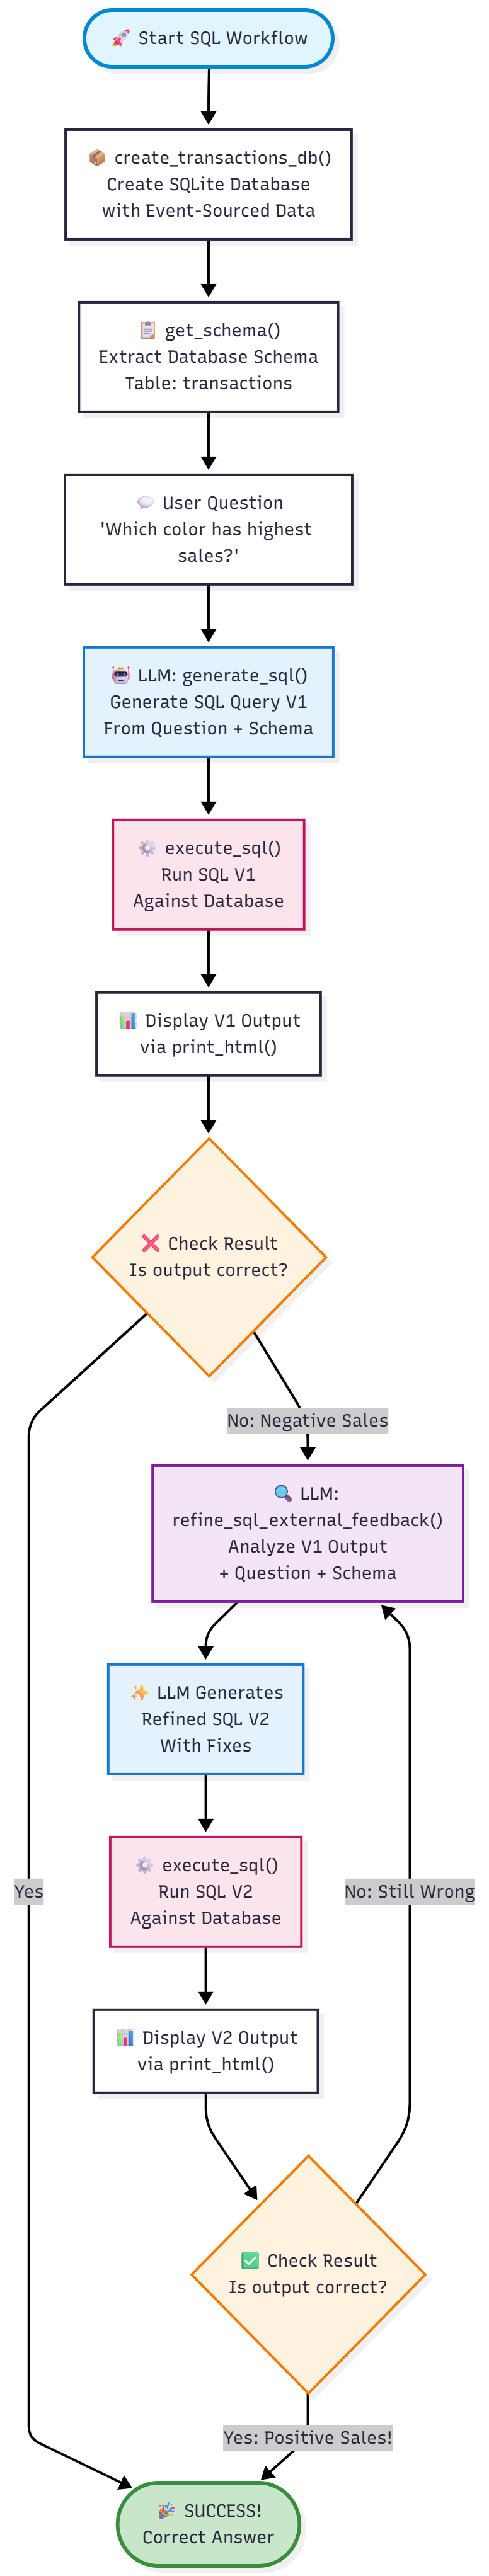